# Exploratory Analysis of Spatial Data: Visualizing Spatial Autocorrelation with `splot` and `esda`

## Content

1. Imports
2. Load Example data
3. Assessing Global Spatial Autocorrelation
4. Visualizing Local Autocorrelation Statistics with `splot`
5. Combined visualizations: Moran Local Scatterplot, LISA clustermap and Choropleth map
6. Bivariate Moran Statistics

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

## Example Data

First, we will load the Guerry.shp data from `examples` in `libpysal`.

In [2]:
guerry = examples.load_example('Guerry')
link_to_data = guerry.get_path('guerry.shp')
gdf = gpd.read_file(link_to_data)

For this example we will focus on the Donatns (charitable donations per capita) variable. We will calculate Contiguity weights `w` with `libpysals` `Queen.from_dataframe(gdf)`. Then we transform our weights to be row-standardized.

In [3]:
y = gdf['Donatns'].values
w = Queen.from_dataframe(gdf)
w.transform = 'r'

/var/folders/s0/mj_w2cpj0xl1dy841kmxl7zh0000gp/T/ipykernel_59409/2713379574.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


## Assessing Global Spatial Autocorrelation

We calculate Moran's I. A test for global autocorrelation for a continuous attribute.

In [4]:
from esda.moran import Moran

w = Queen.from_dataframe(gdf)
moran = Moran(y, w)
moran.I

/var/folders/s0/mj_w2cpj0xl1dy841kmxl7zh0000gp/T/ipykernel_59409/1127328127.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


np.float64(0.3533613255848608)

Our value for the statistic is interpreted against a reference distribution under the null hypothesis of complete spatial randomness. PySAL uses the approach of random spatial permutations.

In [5]:
from splot.esda import moran_scatterplot

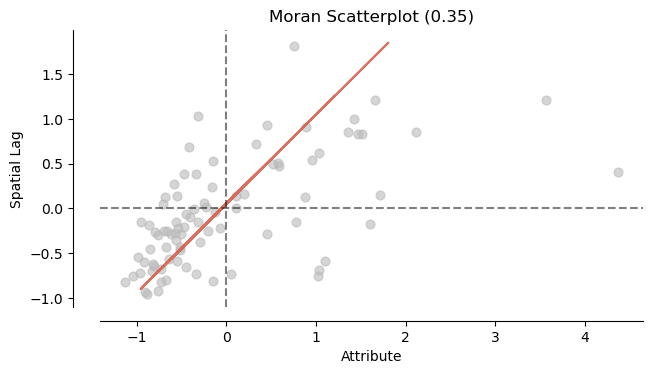

In [6]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

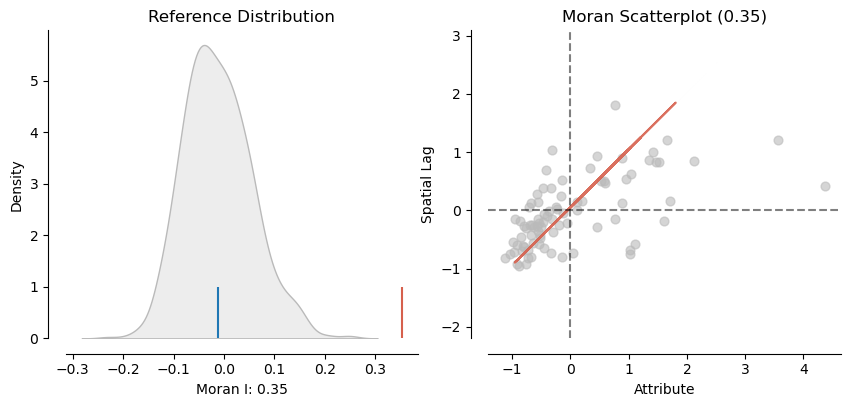

In [7]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

Our observed value is statistically significant:

In [8]:
moran.p_sim

0.001

## Visualizing Local Autocorrelation with splot - Hot Spots, Cold Spots and Spatial Outliers

In addition to visualizing Global autocorrelation statistics, splot has options to visualize local autocorrelation statistics. We compute the local Moran `m`. Then, we plot the spatial lag and the Donatns variable in a Moran Scatterplot.

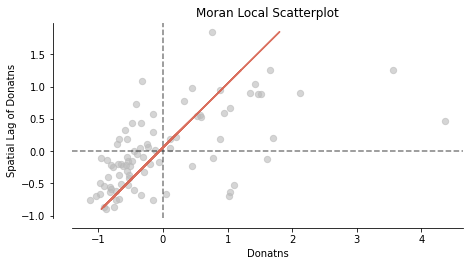

In [9]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

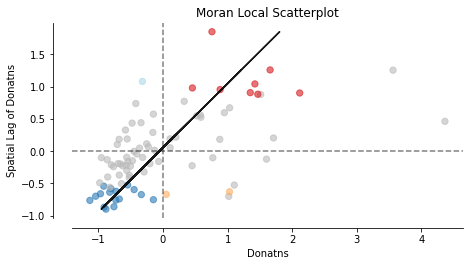

In [10]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

We can distinguish the specific type of local spatial autocorrelation in High-High, Low-Low, High-Low, Low-High.
Where the upper right quadrant displays HH, the lower left, LL, the upper left LH and the lower left HL.

These types of local spatial autocorrelation describe similarities or dissimilarities between a specific polygon with its neighboring polygons. The upper left quadrant for example indicates that polygons with low values are surrounded by polygons with high values (LH). The lower right quadrant shows polygons with high values surrounded by neighbors with low values (HL). This indicates an association of dissimilar values.

Let's now visualize the areas we found to be significant on a map:

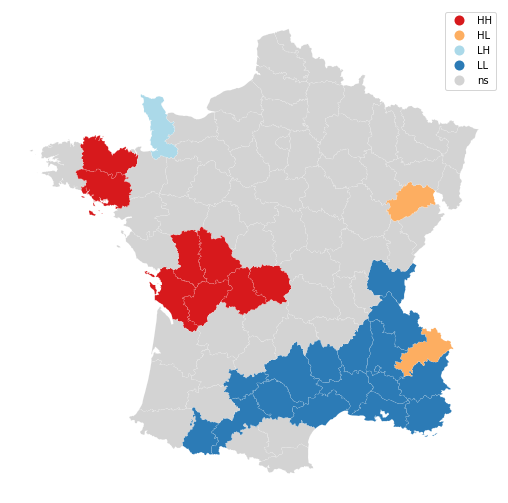

In [11]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
plt.show()

# Combined visualizations

Often, it is easier to asses once statistical results or interpret these results comparing different visualizations.
Here we for example look at a static visualization of a Moran Scatterplot, LISA cluster map and choropleth map.

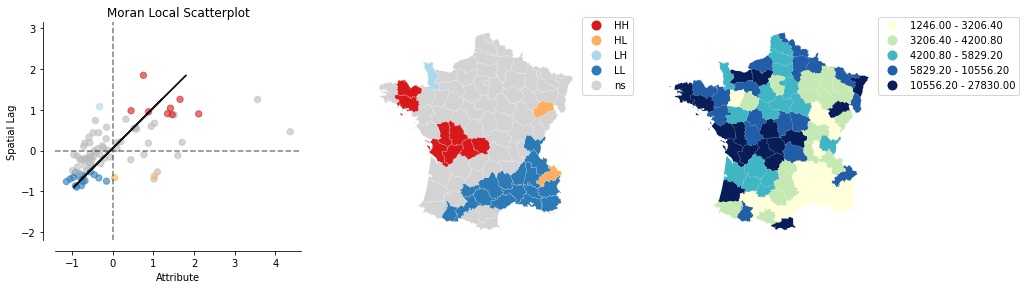

In [12]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, gdf, 'Donatns')
plt.show()

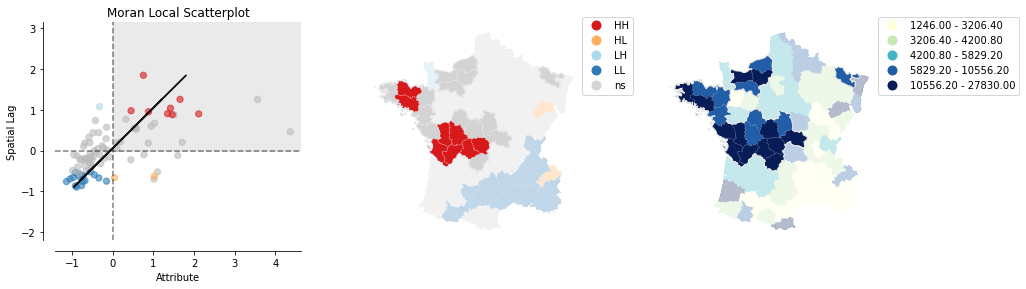

In [13]:
plot_local_autocorrelation(moran_loc, gdf, 'Donatns', quadrant=1)
plt.show()

# Bivariate Moran Statistics

Additionally, to assessing the correlation of one variable over space. It is possible to inspect the relationwhip of two variables and their position in space with so called Bivariate Moran Statistics. These can be found in `esda.moran.Moran_BV`.

In [14]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

Next to `y` we will also be looking at the suicide rate `x`.

In [15]:
x = gdf['Suicids'].values

Before we dive into Bivariate Moran startistics, let's make a quick overview which `esda.moran` objects are supported by `moran_scatterplot`:

In [16]:
moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)

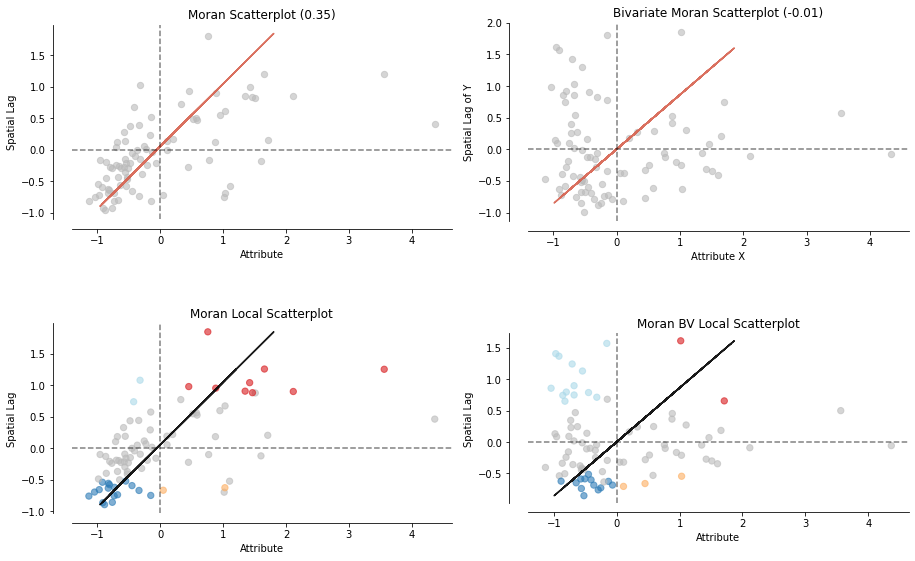

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15,10),
                        subplot_kw={'aspect': 'equal'})

moran_scatterplot(moran, ax=axs[0,0])
moran_scatterplot(moran_loc, p=0.05, ax=axs[1,0])
moran_scatterplot(moran_bv, ax=axs[0,1])
moran_scatterplot(moran_loc_bv, p=0.05, ax=axs[1,1])
plt.show()

As you can see an easy `moran_scatterplot` call provides you with loads of options. Now what are Bivariate Moran Statistics?

Bivariate Moran Statistics describe the correlation between one variable and the spatial lag of another variable. Therefore, we have to be careful interpreting our results. Bivariate Moran Statistics do not take the inherent correlation between the two variables at the same location into account. They much more offer a tool to measure the degree one polygon with a specific attribute is correlated with its neighboring polygons with a different attribute.

`splot` can offer help interpreting the results by providing visualizations of reference distributions and a Moran Scatterplot:

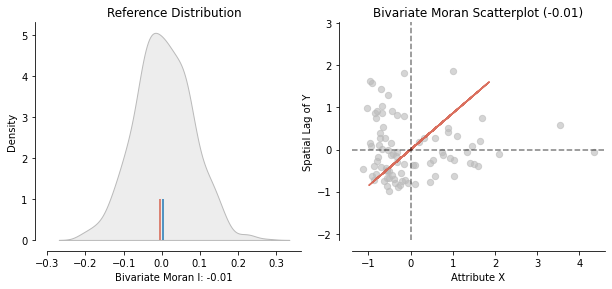

In [18]:
plot_moran_bv(moran_bv)
plt.show()

## Local Bivariate Moran Statistics

Similar to univariate local Moran statistics `pysal` and `splot` offer tools to asses local autocorrelation for bivariate analysis:

In [19]:
from esda.moran import Moran_Local_BV

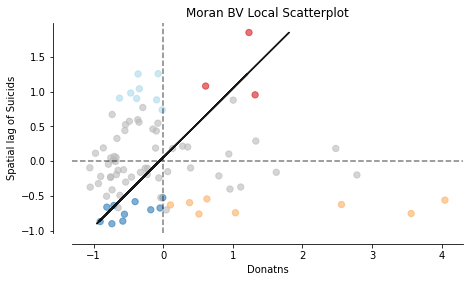

In [20]:
moran_loc_bv = Moran_Local_BV(x, y, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial lag of Suicids')
plt.show()

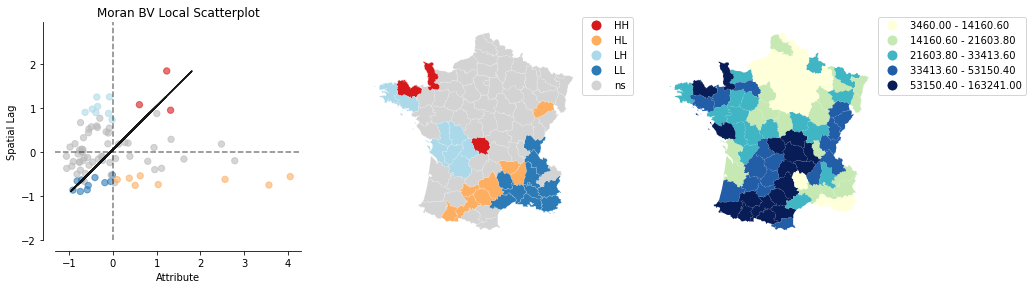

In [21]:
plot_local_autocorrelation(moran_loc_bv, gdf, 'Suicids')
plt.show()